In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0


env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn


In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [4]:
from utils import data_utils

data = data_utils.POWER()

dim = data.n_dims
num_layers = 5


In [5]:
X_train_tensor = torch.from_numpy(data.trn.x)
X_test_tensor = torch.from_numpy(data.tst.x)

In [6]:
def init_weights(m):
    if 'Linear' in str(type(m)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [7]:
from torch.distributions import MultivariateNormal

prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                           torch.eye(data.n_dims).to(device))


In [8]:
from src.mrartemev_nflib.flows import NormalizingFlowModel, InvertiblePermutation, MAF
from src.mrartemev_nflib.nn import ARMLP

flows = []
for _ in range(num_layers):
    flows.append(MAF(dim=data.n_dims, base_network=ARMLP))
    flows.append(InvertiblePermutation(dim=data.n_dims))
model = NormalizingFlowModel(prior, flows).apply(init_weights).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

dloader = DataLoader(TensorDataset(X_train_tensor), batch_size=2**14,
                     shuffle=True, drop_last=True, num_workers=4)
test_dloader = DataLoader(TensorDataset(X_test_tensor), batch_size=2**14,
                          shuffle=True, drop_last=True, num_workers=4)


In [10]:
from IPython.display import clear_output
from tqdm import tqdm


epoches = 50000
plot_freq = 20

epoch_losses = []
train_losses = []

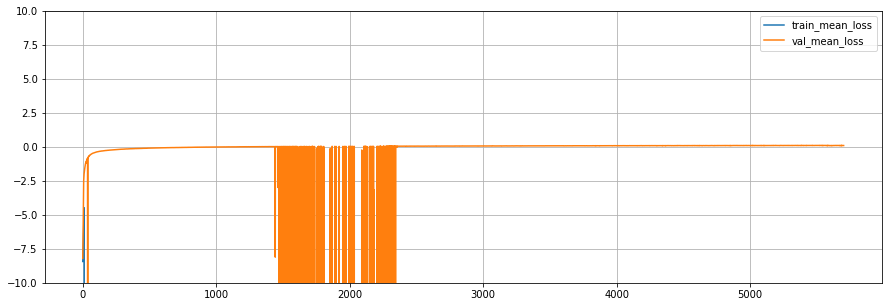

 11%|█▏        | 5708/50000 [8:25:20<65:21:14,  5.31s/it]


KeyboardInterrupt: 

In [11]:
for epoch in tqdm(range(epoches), position=0):
    for ind, batch in enumerate(dloader):
        model.train()
        
        # fit
        optimizer.zero_grad()
        logp_x = model.log_prob(batch[0].to(device))
        if torch.isnan(logp_x).sum() > 0:
            print(epoch, ind, 'contaminated')
#         logp_x = logp_x[~torch.isnan(logp_x)]
        loss = -torch.mean(logp_x)
        loss.backward()
        
        # clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                
        # step
        optimizer.step()

        # log
        train_losses.append(-loss.item())
        
    with torch.no_grad():
        model.eval()
        logp_x = np.mean([torch.mean(model.log_prob(batch[0].to(device))).item() for batch in test_dloader])
        epoch_losses.append([np.mean(train_losses), logp_x])
    
    if epoch % plot_freq == 0 and epoch != 0:
        clear_output(True)
        plt.figure(figsize=(15, 5))
        val_losses = np.array(epoch_losses)
        plt.plot(val_losses[:, 0], label='train_mean_loss')
        plt.plot(val_losses[:, 1], label='val_mean_loss')
        plt.ylim(-10, 10)
        plt.grid()
        plt.legend()
        plt.show()
        

In [30]:
torch.save(model.state_dict(), '../models/POWER5_50k.state_dict')
torch.save(optimizer.state_dict(), '../models/optimizer_POWER5_50k.state_dict')

In [32]:
model.load_state_dict(torch.load('../models/POWER5_50k.state_dict'))

<All keys matched successfully>

Model eval + move model to cpu

In [59]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from src.nf import CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf
from scipy.special import logsumexp


In [58]:
model.eval()
model.sample_n = lambda x: model.sample(x)

model.cpu()
model.prior = MultivariateNormal(torch.zeros(data.n_dims),
                                 torch.eye(data.n_dims))


print('Model train LL ', torch.mean(model.log_prob(X_train_tensor)).item())
print('Model test LL ', torch.mean(model.log_prob(X_test_tensor)).item())


Model train LL  0.12214767187833786
Model test LL  0.10068212449550629


In [60]:
n = 100000

clf_ds_train = np.row_stack([
    np.column_stack([X_train_tensor.detach().numpy()[:n], np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample(n).detach().numpy()[:n], np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_ds_test = np.row_stack([
    np.column_stack([X_test_tensor.detach().numpy()[:n], np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample(n).detach().numpy()[:n], np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

In [61]:
clf = CatBoostClassifier(
    1000, eval_metric='AUC',
    metric_period=200,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

Learning rate set to 0.117291
0:	test: 0.5276902	best: 0.5276902 (0)	total: 25ms	remaining: 24.9s
200:	test: 0.6901540	best: 0.6901540 (200)	total: 3.57s	remaining: 14.2s
400:	test: 0.7026834	best: 0.7026834 (400)	total: 7.21s	remaining: 10.8s
600:	test: 0.7074243	best: 0.7074243 (600)	total: 10.9s	remaining: 7.22s
800:	test: 0.7096149	best: 0.7096149 (800)	total: 14.6s	remaining: 3.62s
999:	test: 0.7110132	best: 0.7110132 (999)	total: 18.3s	remaining: 0us

bestTest = 0.7110132447
bestIteration = 999



In [63]:
calibrated_model = CalibratedModel(clf, model, logit=True)

samples = model.sample(10000).detach().cpu().numpy()
clf_preds = clf.predict(samples, prediction_type='RawFormulaVal')
calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))

-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor) - calibration_constant,

(0.10068212449550629, 0.40013884790857673)

In [64]:
clf2000 = CatBoostClassifier(
    2000, eval_metric='AUC',
    metric_period=500,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

samples = model.sample(10000).detach().cpu().numpy()
clf_preds = clf2000.predict(samples, prediction_type='RawFormulaVal')
calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))

calibrated_model2000 = CalibratedModel(clf2000, model, logit=True)

-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model2000, X_test_tensor)

Learning rate set to 0.086759
0:	test: 0.5276902	best: 0.5276902 (0)	total: 24.4ms	remaining: 48.7s
500:	test: 0.7014393	best: 0.7014393 (500)	total: 9.05s	remaining: 27.1s
1000:	test: 0.7094012	best: 0.7094012 (1000)	total: 18.3s	remaining: 18.2s
1500:	test: 0.7119515	best: 0.7119515 (1500)	total: 27.5s	remaining: 9.15s
1999:	test: 0.7126400	best: 0.7126400 (1999)	total: 36.8s	remaining: 0us

bestTest = 0.7126399621
bestIteration = 1999



(0.10068212449550629, 0.4087391211954767)